# Is a good beer a good beer everywhere?

How do liked beers differ locally and globally (maybe choose the most “important” beers and show on the map in different colors/shadings how popular they are in the different states)?

In [1]:
import pandas as pd
import numpy as np
import gzip #to read gzip files
import matplotlib.pyplot as plt
import datetime
import pickle

## Data extraction and viewing

We start by extracting the data for beers, breweries and users from the two rating websites BeerAdvocate and RateBeer as well as the matched data. We view the dataframe first few rows to get a sense of what the data contains.

In [2]:
PATH = '../'

### BeerAdvocate data

In [3]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


In [4]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(2)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.000000,1.0
1,6.0,3.86,3.888750,3.768333,NaN,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754,0.527141,1.0


In [5]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')
BA_breweries.head(2)

,location,name,nbr_beers
id,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
39913,Kyrgyzstan,Arpa (АРПА),1


### RateBeer data

In [6]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')
RB_breweries.head(2)

,location,name,nbr_beers
id,,,
3198,Gabon,Sobraga,3
13538,Northern Ireland,Ards Brewing Co.,13


In [7]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(2)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596


In [8]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users['joined'] = pd.to_datetime(BA_users['joined'],unit = 's')
BA_users.head(2)

,nbr_ratings,nbr_reviews,user_name,joined,location
user_id,,,,,
nmann08.184925,7820,465,nmann08,2008-01-07 11:00:00,"United States, Washington"
stjamesgate.163714,2521,2504,StJamesGate,2007-10-08 10:00:00,"United States, New York"


In [9]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users['joined'] = pd.to_datetime(RB_users['joined'] ,unit = 's')
RB_users.head(2)

,nbr_ratings,user_name,joined,location
user_id,,,,
175852,1890,Manslow,2012-05-20 10:00:00,Poland
442761,89,MAGICuenca91,2017-01-10 11:00:00,Spain


### Matched data

In [10]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users['joined'] = pd.to_datetime(matched_users['joined'],unit = 's')
matched_users['joined.1'] = pd.to_datetime(matched_users['joined.1'],unit = 's')
matched_users.head(2)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,2008-09-08 10:00:00,Germany,6,6,erzengel.248045,Erzengel,erzengel,2008-10-18 10:00:00,Germany,8781,83106,Erzengel,erzengel
1,2012-09-23 10:00:00,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,2013-11-29 11:00:00,"United States, Virginia",6240,290599,GenDV138,gendv138


Next we extract the reviews from the different datasets :

### Extracting BeerAdvocate reviews

In [11]:
#open the csv file
df_BA_reviews = pd.read_csv('../BeerAdvocate/df_BA_reviews.csv')
df_BA_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...


### Extracting RateBeer reviews:

In [12]:
#open the csv file
df_RB_reviews = pd.read_csv('../RateBeer/df_RB_reviews_final.csv')
df_RB_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...


# Some preprocessing <br>
## Run these cells only once, then save the dataframe. <br>
## Afterwards you can just load the dataframes and don't loose time to run all the computations again

The dates in df_reviews are saved as strings. <br>
A first step (will be important later) is to transform them to datetime. <br>
Probably this step we will have to do everytime we load the csv file.

In [13]:
#Transform the dates of the reviews from string to datetime
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

To allow the merge of the brewery location with the brewery name on df_reviews, we first need to align the column names. <br>
To do so we rename the column "name" of breweries to "brewery_name" (the name of the column in df_reviews). <br>

We use the function df.merge to add the element "location" to the corresponding brewery in df_reviews. <br>
By default the new columns name would be the same as in df_breweries ('location'), we rename it by "brewery_location" to prevent confusion. <br>

After the merging we rename the column of the brewery dataframe again, to have the same name that we had initially.

In [14]:
#Rename the column name to brewery_name to allow merging with the 
BA_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)
RB_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)


#Add the location to the beer dataframe
df_BA_reviews = (df_BA_reviews.merge(BA_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})
df_RB_reviews = (df_RB_reviews.merge(RB_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})


#Name the columns back: 
BA_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)
RB_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)

As the different states of the US are described as different locations, but sometimes we want to group the beers by nations and not by states. <br>
To make this possible we add a new column. <br>
This column is called "brewery_merged_location" and is exactly the same as the column "brewery_location" except for the fact, that the different states of the US all take the value "United States".

In [15]:
# Add a column where all breweries from the united states get 'United States' as location
df_RB_reviews['brewery_merged_location'] = df_RB_reviews['brewery_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'


df_BA_reviews['brewery_merged_location'] = df_BA_reviews['brewery_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

The same approach as for the brewery locations is used to add the country of origin of the users. <br>
To group them by nations we add here a column that sums up the states of the US under the value "United States".

In [16]:
#Add the country of origin of the reviewer to the review
df_RB_reviews = (df_RB_reviews.merge(RB_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})
df_BA_reviews = (df_BA_reviews.merge(BA_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})

# Add a column where all users from the united states get 'United States' as location
df_RB_reviews['brewery_merged_location'] = df_RB_reviews['brewery_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

#For BA we have to replace the NaN values
df_BA_reviews['user_location'] = df_BA_reviews['user_location'].fillna('Unknown')
df_BA_reviews['user_merged_location'] = df_BA_reviews['user_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

To avoid doing this computations every time we want to start coding, I suggest to save the dataframes in your data folder. <br>
I separated the code into two cells as the computation can take several minutes.

In [17]:
#Do that only once. Stores the dataframes so that we can access them more easily next time and have to do the data preprocessing only once
df_BA_reviews.to_csv(PATH+'/DataframeStorage/df_BA_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'], index=False)

In [18]:
df_RB_reviews.to_csv(PATH+'/DataframeStorage/df_RB_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'], index=False)

### Extracting matched data ratings

In [38]:
MD_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', header = 1)
MD_ratings.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,...,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


## Choosing the 20 best beers in the world

The aim of this idea is to choose the top 20 beers in the world and compare locations of users and the brewery locations for the beers in order to see if there is a bias towards local beers.
In order to choose the best beers, we have decided on a certain number of criteria:
1) Beers that have receieved at least x (to be determined below based on statistical information) number of reviews
2) Reviewers that have reviewed more than x (to be determined below based on statistical information) amount of times (if someone rated a beer once only it's maybe not enough), also we have to keep in mind that a lot of people mindlessly rate beers without reviewing them. Hence here we focus on the number of reviews because it means the person took the time and effort to write a review, making the overall rating more legitimate.
3) Extract the top 20 beers according to the average rating across the two websites

### 1) Beers that have recieved a significant number of reviews

First, let's take a look at the distribution of the number of reviews per beer to get a sense of how the x minimal number of reviews a beer should've received in order to select it.

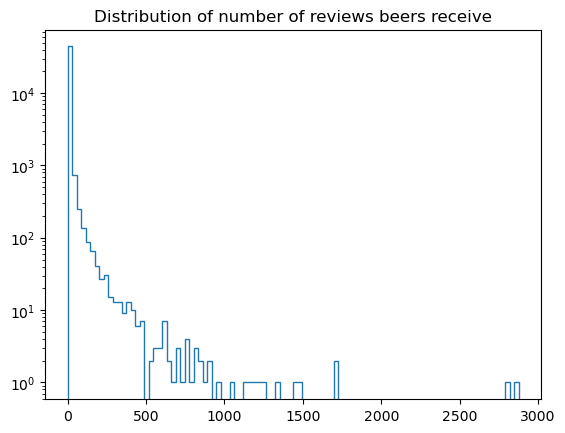

In [14]:
array_100=plt.hist(matched_beers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of number of reviews beers receive')
plt.show()

In [15]:
matched_beers['nbr_reviews'].describe()

count    45640.000000
mean         5.977826
std         40.955440
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       2875.000000
Name: nbr_reviews, dtype: float64

From the statistical description above, we can see that the quantiles are not very interesting for the choice of our treshold since this is a heavy tailed distribution and 75% of the beers have at most 2 reviews. So we choose to take the beers that have received at least 50 reviews which represents around 2% of the data 

In [34]:
print(f'{"Percentage of beer data with more than 50 reviews :"} { round(len(matched_beers[matched_beers["nbr_reviews"]>50])/len(matched_beers["nbr_reviews"])*100,2) }{"%"}')
print(f'{"Number of beers with more than 50 reviews :"} { len(matched_beers[matched_beers["nbr_reviews"]>50]) }')

Percentage of beer data with more than 50 reviews : 1.95%
Number of beers with more than 50 reviews : 890


In [37]:
# Extracting beers which have received more than 50 reviews
top_beers = matched_beers[matched_beers['nbr_reviews']>50]

In [39]:
#We extract the corresponding ratings/reviews from matched data 
top_beers_ratings = MD_ratings[MD_ratings['beer_id'].isin(top_beers['beer_id']) | MD_ratings['beer_id.1'].isin(top_beers['beer_id.1'])]

In [40]:
len(top_beers_ratings) #there are the same beers several times 

10091

### 2) Reviewers that have reviewed more than x amount of times 

Now that we've constructed the dataframe *top_beers_ratings* with the ratings for the beers that are heavily reviewed, we want to look into the reviewers and start by extracting the revieweres who reviewed those beers.

In [72]:
#we extract the users that reviewed the beers that have received more than 50 reviews.
top_beers_reviewers = matched_users[matched_users['user_id'].isin(top_beers_ratings['user_id']) | matched_users['user_id.1'].isin(top_beers_ratings['user_id.1'])]

Let's take a look at the number of ratings per reviewer for the reviewers of the highly reviewed beers: 

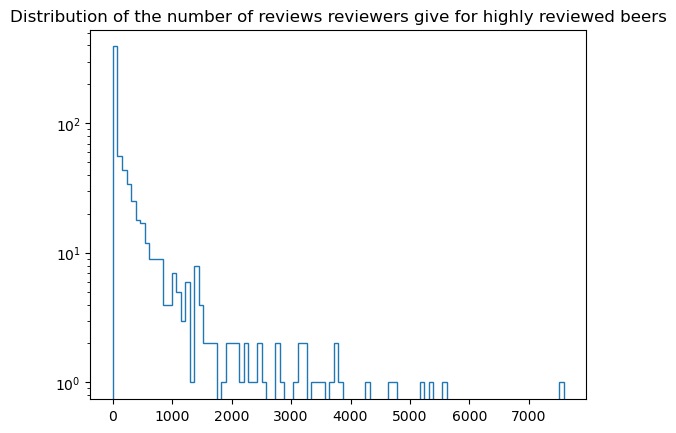

In [76]:
array_100=plt.hist(top_beers_reviewers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of the number of reviews reviewers give for highly reviewed beers')
plt.show()

In [74]:
top_beers_reviewers[['nbr_reviews']].describe()

,nbr_reviews
count,711.000000
mean,365.544304
std,804.331349
min,0.000000
25%,7.000000
50%,54.000000
75%,327.000000
max,7593.000000


Since the mean is close to the median, this is not a heavy tailed distribution (it may be an exponential distribution). Since here the 3rd percentile already represents a significant number of reviews, we choose to select reviewers who have written more than that amount of reviews (327).

In [77]:
#We decide to filter by the reviewers that have put a number of reviews (not ratings) higher than the third percentile
top_beers_reviewers = top_beers_reviewers.loc[top_beers_reviewers['nbr_reviews']>327]

Now we go back to the beers we've extracted earlier and subset them by the reviewers exctracted above

In [78]:
#filtering the beer ratings by the top beer reviewers
top_beers_ratings = top_beers_ratings[top_beers_ratings['user_id'].isin(top_beers_reviewers['user_id']) & top_beers_ratings['user_id.1'].isin(top_beers_reviewers['user_id.1']) ]

### 3) Extract top 20 beers according to the avg rating over the two websites

Now we really want to extract the top 20 beers after all that filtering. We do so by using the beer ratings. Since each website has an average rating the beers, we start by taking the average of these average ratings. Then we select the 20 beers with the highest ratings.

In [89]:
#adding an average of averages column to get the average rating across both websites
top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)
top_20_beers = top_beers.nlargest(20, 'average_avg', keep='all')

/var/folders/vs/4l5nyqs52cj8k63yp80d5cfh0000gn/T/ipykernel_22894/1016610164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)


We subset the review dataframe with those specific beers:

In [90]:
#We extract the ratings for those top20 beers for the top reviewers
top_20_beers_ratings = top_beers_ratings[top_beers_ratings['beer_id'].isin(top_20_beers['beer_id']) & top_beers_ratings['beer_id.1'].isin(top_20_beers['beer_id.1'])]

In [91]:
#Sanity check to make sure that we do have 20 beers
top_20_beers_ratings[['beer_id','beer_id.1']].nunique()

beer_id      20
beer_id.1    20
dtype: int64

In [92]:
# Group by beer id's, since we'll have the same beers several times and both id's should correspond to the same beers. 
top_20_beers_ratings = top_20_beers_ratings.set_index(['beer_id','beer_id.1'])
#we drop beer duplicates since we are only interested in the brewery and user 

In [100]:
top_20_beers_ratings.columns

Index(['abv', 'appearance', 'aroma', 'beer_name', 'brewery_id', 'brewery_name',
       'date', 'overall', 'palate', 'rating', 'review', 'style', 'taste',
       'text', 'user_id', 'user_name', 'abv.1', 'appearance.1', 'aroma.1',
       'beer_name.1', 'brewery_id.1', 'brewery_name.1', 'date.1', 'overall.1',
       'palate.1', 'rating.1', 'style.1', 'taste.1', 'text.1', 'user_id.1',
       'user_name.1'],
      dtype='object')

In [ ]:
top_20_beers_ratings

In [105]:
top_20_beers_ratings[~top_20_beers_ratings.index.duplicated(keep='first')]

,,abv,appearance,aroma,beer_name,brewery_id,brewery_name,date,overall,palate,rating,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
beer_id,beer_id.1,,,,,,,,,,,,,,,,,,,,,
645,2360,11.3,5.00,5.00,Trappistes Rochefort 10,207,Brasserie de Rochefort,1060855200,5.00,5.00,5.00,...,Brasserie Rochefort,1060855200,20.0,5.0,5.0,Abt/Quadrupel,10.0,(330 ml bottle). Pours with an enormous and th...,3343,Sigmund
3833,14232,12.0,4.00,4.00,AleSmith Speedway Stout,396,AleSmith Brewing Company,1388487600,4.50,4.25,4.33,...,AleSmith Brewing Company,1388487600,17.0,4.0,4.2,Imperial Stout,9.0,"Early on 31st Dec 13, usual 0.75 litre bottle ...",97853,BlackHaddock
5281,7502,5.0,4.00,4.50,Cantillon Fou' Foune,388,Brasserie Cantillon,1112263200,4.00,3.50,4.07,...,Cantillon,1112090400,15.0,3.0,3.6,Lambic Style - Fruit,7.0,"On tap the the Sunset Grill, only 5$! Calm hea...",8034,Rastacouere
47088,95636,5.0,4.00,4.00,Cantillon Crianza Helena,388,Brasserie Cantillon,1262170800,4.50,4.50,4.35,...,Cantillon,1397815200,18.0,4.0,4.3,Lambic Style - Gueuze,8.0,Bottle @ RBBSG II. Courtesy of Travlr! Pours a...,74220,ThirstyBird
69522,145903,8.0,4.25,4.50,Double Citra,22511,Hill Farmstead Brewery,1467626400,4.25,4.25,4.41,...,Hill Farmstead Brewery,1467626400,15.0,4.0,4.1,Imperial IPA,9.0,Draught @ Armsby Abby: This one poured a hazy ...,154,boto
117177,258973,8.0,4.00,4.50,Sip Of Sunshine IPA,17980,Lawson's Finest Liquids,1436436000,4.50,4.75,4.50,...,Lawsons Finest Liquids,1452164400,18.0,5.0,4.5,Imperial IPA,9.0,Draught @ Cambridge House: This one pours a ha...,154,boto
8983,21457,7.0,4.50,4.50,Drie Fonteinen Millennium Geuze,2216,Brouwerij 3 Fonteinen,1297594800,4.50,4.50,4.50,...,Brouwerij 3 Fonteinen,1339063200,17.0,4.0,4.3,Lambic Style - Gueuze,9.0,Consumed January 2011.A: Golden-straw body wit...,92897,callmemickey
64545,134550,8.0,NaN,NaN,Double Sunshine IPA,17980,Lawson's Finest Liquids,1359630000,NaN,NaN,4.50,...,Lawsons Finest Liquids,1339236000,17.0,4.0,4.2,Imperial IPA,9.0,A: Hazy apricot colored body. Large fluffy wh...,92897,callmemickey
36316,66438,5.0,5.00,4.50,Cantillon Blåbær Lambik,388,Brasserie Cantillon,1262343600,5.00,4.50,4.83,...,Cantillon,1375005600,17.0,4.0,4.4,Lambic Style - Fruit,9.0,2009 375ml bottle opened January 2010A: Rich r...,92897,callmemickey


In [95]:
beer_multiindex = top_20_beers_ratings.index

In [96]:
unique_beer_ids = top_20_beers_ratings.index.drop_duplicates()

In [254]:
beer_locations = pd.DataFrame(columns=['beer_id','beer_id.1','brewery_location','brewery_location.1'])
user_locations = pd.DataFrame(columns=['beer_id', 'beer_id.1', 'user_id', 'user_id.1','user_location', 'user_location.1'])

In [265]:
top_20_beers_ratings.columns

Index(['abv', 'appearance', 'aroma', 'beer_name', 'brewery_id', 'brewery_name',
       'date', 'overall', 'palate', 'rating', 'review', 'style', 'taste',
       'text', 'user_id', 'user_name', 'abv.1', 'appearance.1', 'aroma.1',
       'beer_name.1', 'brewery_id.1', 'brewery_name.1', 'date.1', 'overall.1',
       'palate.1', 'rating.1', 'style.1', 'taste.1', 'text.1', 'user_id.1',
       'user_name.1'],
      dtype='object')

In [266]:
beer_locations_test = top_20_beers_ratings[~top_20_beers_ratings.index.duplicated(keep='first')][['brewery_id','brewery_id.1','user_id','user_id.1']] 

In [280]:
brewery_locations = matched_breweries[matched_breweries['id'].isin(beer_locations_test['brewery_id']) & matched_breweries['id.1'].isin(beer_locations_test['brewery_id.1'])]
brewery_locations = brewery_locations[['id','id.1','location', 'location.1']]

In [283]:
brewery_locations.set_index(['id','id.1'])

,,location,location.1
id,id.1,,
396,432,"United States, California","United States, California"
20680,10514,"United States, Washington","United States, Washington"
26676,13267,"United States, New Jersey","United States, New Jersey"
23222,11242,"United States, Iowa","United States, Iowa"
22511,11233,"United States, Vermont","United States, Vermont"
17980,9863,"United States, Vermont","United States, Vermont"
20681,10659,"United States, Maine","United States, Maine"
33519,18813,"United States, Maine","United States, Maine"
207,406,Belgium,Belgium


In [ ]:
beer_locations = []
breweries_locations = []

for i in beer_multiindex
    beer_breweries= top_20_beers.loc[ (top_20_beers['beer_id'] == beer_multiindex[i][0]) & (top_20_beers['beer_id.1'] ==  beer_multiindex[i][1])][['brewery_id','brewery_id.1']]

### Comparing breweries locations and reviewers location

In [107]:
#we extract the breweries that correspond to the top 20 beers
top_20_beers_breweries= matched_breweries[matched_breweries['id'].isin(top_20_beers['brewery_id']) & matched_breweries['id.1'].isin(top_20_beers['brewery_id.1'])]

In [186]:
# We observe that there are only 12 corresponding breweries because there are several beers produced by the same breweries
len(top_20_beers_breweries)

12

In [188]:
top_20_beers_breweries

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
4067,396,"United States, California",AleSmith Brewing Company,288,432,"United States, California",AleSmith Brewing Company,261,0.658297,1.000000
4469,20680,"United States, Washington",Fremont Brewing Company,176,10514,"United States, Washington",Fremont Brewing Company,191,0.360245,1.000000
4632,26676,"United States, New Jersey",Kane Brewing Company,228,13267,"United States, New Jersey",Kane Brewing Company,166,0.658297,1.000000
5818,23222,"United States, Iowa",Toppling Goliath Brewing Company,93,11242,"United States, Iowa",Toppling Goliath,84,0.719506,0.968504
6165,22511,"United States, Vermont",Hill Farmstead Brewery,222,11233,"United States, Vermont",Hill Farmstead Brewery,239,0.550189,1.000000
6171,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89,1.000000,1.000000
6459,20681,"United States, Maine",Maine Beer Company,48,10659,"United States, Maine",Maine Beer Company,44,0.305457,1.000000
6488,33519,"United States, Maine",Bissell Brothers Brewing Co.,37,18813,"United States, Maine",Bissell Brothers Brewing Company,29,0.423924,0.923321
7395,207,Belgium,Brasserie de Rochefort,3,406,Belgium,Brasserie Rochefort,3,0.531187,0.923711
7443,388,Belgium,Brasserie Cantillon,82,1069,Belgium,Cantillon,77,0.480277,0.905220


In [108]:
top_20_beers.merge(top_20_beers_breweries)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,sim,average_avg,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1
0,7.0,4.55,4.553939,4.552029,96.0,44910,Dirty Horse,Horse Dirty,15237,De Struise Brouwers,...,1.0,4.370,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89
1,5.0,4.52,4.521396,4.514030,99.0,36316,Cantillon Blåbær Lambik,Blåbær Lambik,388,Brasserie Cantillon,...,1.0,4.345,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89
2,5.0,4.42,4.468350,4.406739,96.0,47088,Cantillon Crianza Helena,Helena Crianza,388,Brasserie Cantillon,...,1.0,4.320,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89
3,5.0,4.54,4.650579,4.522328,100.0,5281,Cantillon Fou' Foune,Fou Foune,388,Brasserie Cantillon,...,1.0,4.295,17980,"United States, Vermont",Lawson's Finest Liquids,103,9863,"United States, Vermont",Lawsons Finest Liquids,89


Aligned data = matched breweries and matched beers so not same reviewer potentially 

Extraire les noms des reviewer  (user_id et user_id.1 sont les memes dans matched_users) + pays d'origine + le nb de REVIEWS qu'ils ont mis (1 et 2): filter selon si l'un ou l'autre a mis plus que x review -> filter top_beers avec ces users en utilisant MD_users

Extraire de top_beers les bieres top 22 avg (average des avg.1 et avg.2) + pays en utilisant brewery id 

trouver une raison pour le choix des treshold nbr of reviews

Repeter ca par region?

# Flos code:

## Chinas beers correlate with how US citizens view China:

In [17]:
print(len(RB_breweries[RB_breweries['location']=='China']))
print(len(BA_breweries[BA_breweries['location']=='China']))

188
66


In [23]:
chinese_breweries_RB = RB_breweries[RB_breweries['location']=='China']
chinese_breweries_BA = BA_breweries[BA_breweries['location']=='China']

In [21]:
#As the same breweries have not exactly the same wording, we concatenate the two dataframes.
chinese_breweries = pd.concat([chinese_breweries_RB['name'], (chinese_breweries_BA['name'])], axis=0)

id
29441    申爱 Shanghai Love Brewing Co.
Name: name, dtype: object

In [25]:
len(df_BA_reviews[df_BA_reviews['brewery_name'].isin([chinese_breweries])])

0

In [26]:
len(df_RB_reviews[df_RB_reviews['brewery_name'].isin([chinese_breweries])])

0

There are no ratings about chinese beers neither in BA nor in RB.

## Influence of Brexit on british reviews in the US:

First we check out from when to when we have data. The brexit referendum was in June 2016, to find any influence of the Brexit result on US beer ratings of british beer we need reviews before and after the votation.

In [29]:
print(df_BA_reviews.date.max())
print(df_BA_reviews.date.min())

2017-08-01 10:00:00
1996-08-22 10:00:00


In [30]:
print(df_RB_reviews.date.max())
print(df_RB_reviews.date.min())

2017-07-31 10:00:00
2000-04-12 10:00:00


### Get Reviews about british beer:

In [38]:
df_british_beers_RB = df_RB_reviews[(df_RB_reviews['brewery_location']=='Northern Ireland') |
                                (df_RB_reviews['brewery_location']=='Wales')  |
                                (df_RB_reviews['brewery_location']=='Scotland') |
                                (df_RB_reviews['brewery_location']=='England')]

df_british_beers_BA = df_BA_reviews[(df_BA_reviews['brewery_location']=='Northern Ireland') |
                                (df_BA_reviews['brewery_location']=='Wales')  |
                                (df_BA_reviews['brewery_location']=='Scotland') |
                                (df_BA_reviews['brewery_location']=='England')]

In [41]:
#count the number of beers we can work with.
print('in RB we have: ' + str(len(df_british_beers_RB)) + ' beers.')
print('in BA we have: ' + str(len(df_british_beers_BA)) + ' beers.')

in RB we have: 774523 beers.
in BA we have: 95800 beers.


In [70]:
brexit_date = datetime.datetime(2016, 6, 23, 0, 0, 0)


print('We have '+ str(len(df_british_beers_BA[df_british_beers_BA['date'] > brexit_date])) +' ratings of british beer in BA')
print('and '+ str(len(df_british_beers_RB[df_british_beers_RB['date'] > brexit_date])) +' ratings of british beer in RA after the brexit')
print('Meaning we can work with ' + str(len(df_british_beers_RB[df_british_beers_RB['date'] > brexit_date]) + len(df_british_beers_BA[df_british_beers_BA['date'] > brexit_date])) +' ratings.')

We have 4363 ratings of british beer in BA
and 107213 ratings of british beer in RA after the brexit
Meaning we can work with 111576 ratings.


# Visualize where most ratings were from:

# Code for Zeina:

This is the code I used to extract the indices of the rows containing words related to can or bottle in their texts. <br>
I added the lists as pickles to the drive. <br>
You can see in the code below how to unpack a pickle into a list again. <br>

Should you need to investigate for other words, you can use the architecture of the code below. <br>
There is a high probability that this is not the most efficient way of doing it, so if you have ideas of improvement I am open :)

In [110]:
words_to_select_can = ['can', 'canned']
words_to_select_bottle = ['bottle', 'bottled']

In [112]:
index_can_R = []
index_bottle_R = []
index_can_B = []
index_bottle_B = []
added_words = []
added_texts = []

k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [113]:
for index, row in df_RB_reviews.iterrows():
    #extract the text
    text = row['text']
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in words_to_select_can]) > 0):
        index_can_R.append(index)
    #Check whether a word related to "bottle" is in the text
    if (len([x for x in words if x in words_to_select_bottle]) > 0):
        index_bottle_R.append(index)

In [129]:
with open("../dataframes_Flo/index_bottle_R.bin", "wb") as output:
    pickle.dump(index_bottle_R, output)

with open("../dataframes_Flo/index_can_R.bin", "wb") as output:
    pickle.dump(index_can_R, output)

In [128]:
for index, row in df_BA_reviews.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in words_to_select_can]) > 0):
        index_can_B.append(index)
    #Check whether a word related to "bottle" is in the text
    if (len([x for x in words if x in words_to_select_bottle]) > 0):
        index_bottle_B.append(index)

In [130]:
with open("../dataframes_Flo/index_bottle_B.bin", "wb") as output:
    pickle.dump(index_bottle_B, output)

with open("../dataframes_Flo/index_can_B.bin", "wb") as output:
    pickle.dump(index_can_B, output)

In [133]:
print('In RB, out of ' + str(len(df_RB_reviews)) + ' reviews, we have ' + str(len(index_bottle_R)) + ' reviews mentioning "bottle" and ' + str(len(index_can_R)) + ' reviews mentioning "cans"')
print('In BA, out of ' + str(len(df_BA_reviews)) + ' reviews, we have ' + str(len(index_bottle_B)) + ' reviews mentioning "bottle" and ' + str(len(index_can_B)) + ' reviews mentioning "cans"')


In RB, out of 7129580 reviews, we have 1041161 reviews mentioning "bottle" and 261858 reviews mentioning "cans"
In BA, out of 2962158 reviews, we have 1058080 reviews mentioning "bottle" and 540167 reviews mentioning "cans"
